In [1]:
!pip install bertopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 4.5 MB/s 
     |████████████████████████████████| 85 kB 5.0 MB/s 
     |████████████████████████████████| 88 kB 7.1 MB/s 
     |████████████████████████████████| 636 kB 8.0 MB/s 
     |████████████████████████████████| 5.2 MB 48.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 4.9 MB 42.9 MB/s 
     |████████████████████████████████| 1.3 MB 47.1 MB/s 
     |████████████████████████████████| 120 kB 46.9 MB/s 
     |████████████████████████████████| 6.6 MB 34.7 MB/s 
     |████████████████████████████████| 1.1 MB 62.3 MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2340252 sha256=ed4e1f348bef89624016a0ffa89d36460c6d2481ab80a5083361c5422ec3f9aa
  Stored in directory: /root/.cache/

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

data = pd.read_parquet("/content/drive/My Drive/Colab Notebooks/Bertopic/twitter_100k_sample.parquet.gzip")

In [4]:
df = data.loc[data.duplicated(subset=['text'])==False]
df = df.loc[df['created_at'] < '2022-08-01']

In [5]:
df['lemmatized_string'] = [' '.join(map(str, l)) for l in df["lemmatized_text"]]

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'fuck','fucking','wth','shit','nicee', 'amp', 'go','smh','ti','kkk'])

In [8]:
df['StringWithoutStopwords'] = df['lemmatized_string'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [9]:
import re

In [10]:
# remove new lines
df['cleanedString'] = df['StringWithoutStopwords'].map(lambda x: re.sub('\n', ' ', x))
# removing links
df['cleanedString'] = df['StringWithoutStopwords'].map(lambda x: re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w\.-]*)', '', x))
# removing RT (retweets)
df['cleanedString'] = df['StringWithoutStopwords'].map(lambda x: re.sub('RT', '', x))
# removing mentions (ex: @user123)
df['cleanedString'] = df['StringWithoutStopwords'].map(lambda x: re.sub('@[A-Za-z0-9\.-_:]+', '', x))
# remove punctuation
df['cleanedString'] =  df['StringWithoutStopwords'].map(lambda x: re.sub('[,\.!?]', '', x))
# lowercase
df['cleanedString'] = df['StringWithoutStopwords'].map(lambda x: x.lower())
df['cleanedString'] = df['StringWithoutStopwords'].map(lambda x: re.sub('_', ' ', x))

In [11]:
df['cleanedString'] = df['cleanedString'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [12]:
from wordcloud import WordCloud

In [13]:
# Create a WordCloud object
wordcloud = WordCloud(width = 1000, height = 500,background_color="black",  contour_width=3, contour_color='steelblue')

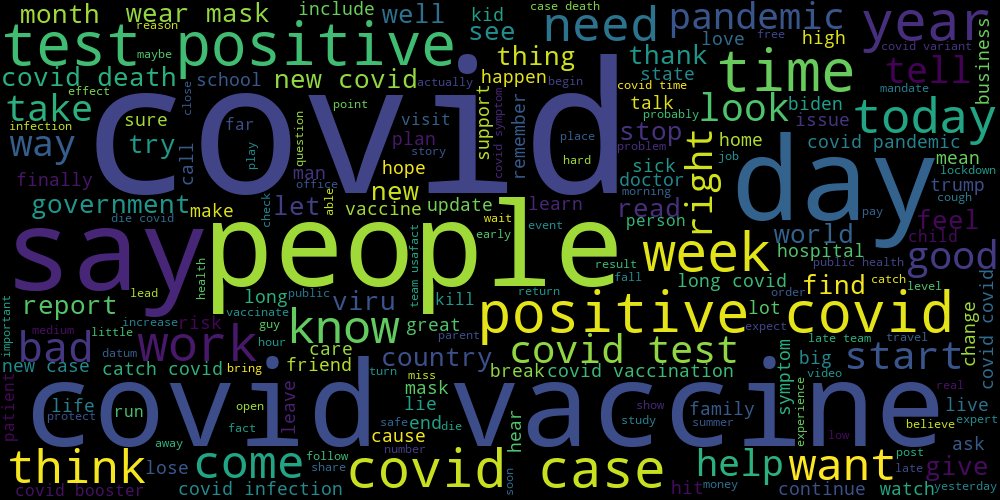

In [14]:
# Generate a word cloud
wordcloud.generate(' '.join(df['cleanedString']))
# Visualize the word cloud
wordcloud.to_image()

In [46]:
docs = df["cleanedString"].to_list()

In [47]:
docs = docs[:100000]

In [ ]:
!pip install sentence_transformers

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

sentence_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")#, device="cuda"
topic_model = BERTopic(language="english",calculate_probabilities=True, verbose=True,n_gram_range=(1, 2),top_n_words=10,embedding_model=sentence_model,nr_topics=10)#,nr_topics=5
topics, probs = topic_model.fit_transform(docs)

Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

2022-09-24 12:55:13,963 - BERTopic - Transformed documents to Embeddings
2022-09-24 12:59:01,747 - BERTopic - Reduced dimensionality


In [40]:
topic_model.visualize_barchart(top_n_topics=11)

In [41]:
import gensim.corpora as corpora
import pandas as pd
from gensim.models.coherencemodel import CoherenceModel

In [42]:
# Preprocess Documents
documents = pd.DataFrame({"Document": docs,
                          "ID": range(len(docs)),
                          "Topic": topics})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

In [43]:
# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

In [44]:
# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model.get_topic(topic)] 
               for topic in range(len(set(topics))-1)]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [45]:
# Evaluate
coherence_model = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='u_mass')
coherence = coherence_model.get_coherence()
coherence#-1.0621414826536855 

-1.0621414826536855